In [ ]:
# script to generate 20 mechanisms with the top 20 parameters to include

# generate the lists of top parameters

In [1]:
import os
import sys
import copy
import pickle
import subprocess

import numpy as np
import rmgpy.chemkin

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
basedir = '/home/moon/autoscience/autoscience/butane/models/rmg_model'

base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)




In [3]:
# get most uncertain reactions
covariance_file = '/home/moon/autoscience/autoscience/uncertainty/butane_covariance.pickle'
with open(covariance_file, 'rb') as handle:
    Sigma_k = pickle.load(handle)
uncorrelated_uncertainties = np.diagonal(Sigma_k)

reaction_indices = np.arange(0, len(reaction_list))
reaction_uncertainty_order = [x for _,x in sorted(zip(uncorrelated_uncertainties, reaction_indices))][::-1]

In [4]:
# get most sensitive reactions
base_delay = 0.14857535
reaction_delay_file = '/home/moon/autoscience/autoscience/butane/sensitivity_analysis/base_rmg24/reaction_ignition_delays_raw.npy'
reaction_delays_raw = np.load(reaction_delay_file)
reaction_sensitivities = ((reaction_delays_raw - base_delay) / base_delay) / 0.1

reaction_sensitivity_order = [x for _,x in sorted(zip(np.abs(reaction_sensitivities), reaction_indices))][::-1]


In [5]:
# Calculate Improvement Score
DFT_error = 3.0
improvement_score = np.abs(reaction_sensitivities) * (uncorrelated_uncertainties - DFT_error)
improvement_score_order = [x for _,x in sorted(zip(improvement_score, reaction_indices))][::-1]

improvement_score2 = np.abs(10.0 * reaction_sensitivities) * (uncorrelated_uncertainties - DFT_error)
improvement_score2_order = [x for _,x in sorted(zip(improvement_score2, reaction_indices))][::-1]

In [6]:
improved = []
for i in range(0, 10):
    rmg_index = improvement_score_order[i]
    print(i, '\t', rmg_index, '\t', improvement_score[rmg_index])
    improved.append(rmg_index)

0 	 915 	 0.007883121305653079
1 	 749 	 0.004083188330406335
2 	 324 	 0.002648895453236761
3 	 419 	 0.0022762961823394883
4 	 1814 	 0.0015613539828551305
5 	 1287 	 0.001453242878526699
6 	 748 	 0.0006130371042672301
7 	 1288 	 0.000594059913355347
8 	 370 	 0.00044590113075130845
9 	 1103 	 0.00015474545400447474


In [7]:
# get most uncertain species
species_uncertainty = '/home/moon/autoscience/autoscience/paper/models/base_rmg/thermo_uncertainty.npy'
species_indices = np.arange(0, len(reaction_list))
uncorrelated_species_uncertainties = np.load(species_uncertainty)
species_uncertainty_order = [x for _,x in sorted(zip(uncorrelated_species_uncertainties, species_indices))][::-1]

In [8]:
# get most sensitive species
base_delay = 0.14857535
species_delay_file = '/home/moon/autoscience/autoscience/butane/sensitivity_analysis/base_rmg24/species_ignition_delays_raw.npy'
species_delays_raw = np.load(species_delay_file)
species_sensitivities = ((species_delays_raw - base_delay) / base_delay) / 0.1

species_sensitivity_order = [x for _,x in sorted(zip(np.abs(species_sensitivities), species_indices))][::-1]


In [9]:
# Calculate Improvement Score
DFT_error = 3.0
species_improvement_score = np.abs(species_sensitivities) * (uncorrelated_species_uncertainties - DFT_error)
species_improvement_score_order = [x for _,x in sorted(zip(species_improvement_score, species_indices))][::-1]

In [10]:
# concatenate species then reactions to sort total
total_sensitivities = np.concatenate((species_sensitivities, reaction_sensitivities))
total_uncertainties = np.concatenate((uncorrelated_species_uncertainties, uncorrelated_uncertainties))
total_indices = np.arange(0, len(species_list) + len(reaction_list))


total_improvement_score = np.abs(total_sensitivities) * (total_uncertainties - DFT_error)
total_improvement_score_order = [x for _,x in sorted(zip(total_improvement_score, total_indices))][::-1]


In [12]:
for i in range(0, 50):
    rmg_index = total_improvement_score_order[i]
    if rmg_index > 110:
        rmg_index -= 110
    print(i, '\t', rmg_index, '\t', total_improvement_score[rmg_index])


0 	 87 	 0.020254167848866477
1 	 915 	 -0.001128060796644457
2 	 749 	 1.0743988765300556e-06
3 	 324 	 1.9227460160988265e-07
4 	 419 	 -0.0
5 	 1814 	 -0.009443727926597801
6 	 1287 	 -5.746592936397052e-07
7 	 748 	 -0.0
8 	 1288 	 -5.073838374611917e-07
9 	 370 	 -0.020650526323552756
10 	 1103 	 -2.0328389238283784e-07
11 	 371 	 -1.7324634498133803e-06
12 	 213 	 -1.4022908541539726e-06
13 	 90 	 0.0001160033726856022
14 	 420 	 -0.0
15 	 581 	 -0.0
16 	 464 	 -0.15648536594699425
17 	 1289 	 2.9453344361346544e-07
18 	 109 	 1.8517165051677447e-05
19 	 720 	 -0.0011090934417141542
20 	 722 	 -0.0
21 	 1658 	 1.5884294358755427e-06
22 	 574 	 2.528392494221218e-05
23 	 725 	 -4.319491389225878e-08
24 	 1736 	 -0.0
25 	 418 	 -0.0
26 	 1290 	 -8.072853901962475e-09
27 	 1721 	 -0.0
28 	 1665 	 1.3214305506556732e-06
29 	 1685 	 -0.0
30 	 427 	 -1.0381252897766913
31 	 1714 	 -0.0
32 	 1766 	 -0.00026372493182079436
33 	 655 	 -1.0348761905653043e-05
34 	 1773 	 -3.042531051652001

In [ ]:
total_improvement_score_order[31] - len(species_list)

In [ ]:
total_improvement_score2 = np.abs(10.0 * total_sensitivities) * (total_uncertainties - DFT_error)
total_improvement_score2_order = [x for _,x in sorted(zip(total_improvement_score2, total_indices))][::-1]

In [13]:
# check which of the top 50 reactions weren't successfully calculated

DFT_DIR = "/home/moon/autoscience/autoscience/butane/dft/"
DFT_DIR = "/home/moon/autoscience/reaction_calculator/dft"
kinetics_lib = os.path.join(DFT_DIR, 'kinetics', 'kinetics')
ark_kinetics_database = rmgpy.data.kinetics.KineticsDatabase()
ark_kinetics_database.load_libraries(kinetics_lib)
print(f'{len(ark_kinetics_database.libraries[""].entries)} kinetics entries loaded')

48 kinetics entries loaded


In [14]:
display(reaction_list[0])

no reaction calculated for Disproportionation, 915


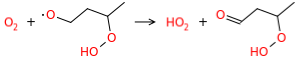

no reaction calculated for Disproportionation, 1814


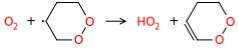

no reaction calculated for H_Abstraction, 1288


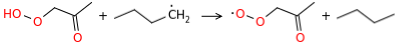

no reaction calculated for Disproportionation, 1736


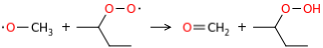

no reaction calculated for Disproportionation, 418


no reaction calculated for Disproportionation, 1721


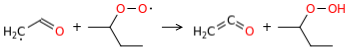

no reaction calculated for Disproportionation, 1665


no reaction calculated for Disproportionation, 427


no reaction calculated for Disproportionation, 1766


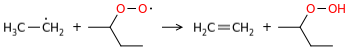

no reaction calculated for Disproportionation, 1773


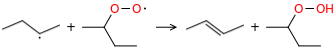

no reaction calculated for Disproportionation, 918


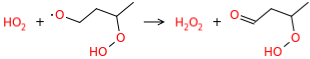

no reaction calculated for H_Abstraction, 692


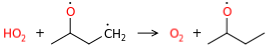

no reaction calculated for Disproportionation, 1428


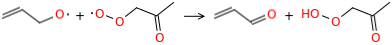

no reaction calculated for Disproportionation, 595


no reaction calculated for Disproportionation, 693


no reaction calculated for Disproportionation, 1242


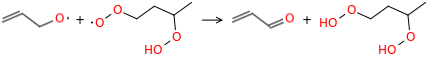

16


In [15]:
skipped_calcs = []
count = 0
for i in range(0, 50):
    rmg_index = total_improvement_score_order[i]
#     rmg_index = total_improvement_score2_order[i]
    
    if rmg_index < len(species_list):  # skip thermo because these were all calculated
        continue
    
    rmg_index -= len(species_list)
    
    match_found = False
    for entry in ark_kinetics_database.libraries[""].entries:
        ref_rxn = ark_kinetics_database.libraries[""].entries[entry].item
        if ref_rxn.is_isomorphic(reaction_list[rmg_index]):
            match_found = True
            break
    if not match_found:
        print(f'no reaction calculated for {reaction_list[rmg_index].family}, {rmg_index}')
        display(reaction_list[rmg_index])
        count += 1
        skipped_calcs.append(rmg_index)
print(count)

In [16]:
skipped_calcs

[915,
 1814,
 1288,
 1736,
 418,
 1721,
 1665,
 427,
 1766,
 1773,
 918,
 692,
 1428,
 595,
 693,
 1242]

In [ ]:
reaction_list[1766]

In [ ]:
species_list[59]

In [17]:
total_improvement_score_order[0]

87

# Generate the Mechanisms

In [22]:
save_dir = '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs'
for e in range(0, 51):    
    
    rmg_index = total_improvement_score_order[e]
    if rmg_index > 110:
        rmg_index -= 110
    if rmg_index in skipped_calcs:
        print('skipping missing calculation', rmg_index)
        continue
    
    print('compiling top', e)
    # load the base mechanism
    basedir = '/home/moon/autoscience/autoscience/butane/models/rmg_model'
    base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
    dictionary = os.path.join(basedir, 'species_dictionary.txt')
    transport = os.path.join(basedir, 'tran.dat')
    species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)

    # Load the new kinetics library
#     DFT_DIR = "/work/westgroup/harris.se/autoscience/autoscience/butane/dft/"
#     DFT_DIR = "/home/moon/autoscience/autoscience/butane/dft/"
    DFT_DIR = "/home/moon/autoscience/reaction_calculator/dft/"
    kinetics_lib = os.path.join(DFT_DIR, 'kinetics', 'kinetics')
    ark_kinetics_database = rmgpy.data.kinetics.KineticsDatabase()
    ark_kinetics_database.load_libraries(kinetics_lib)
    print(f'{len(ark_kinetics_database.libraries[""].entries)} kinetics entries loaded')
    
    # Load the new thermo library
#     thermo_lib = os.path.join(DFT_DIR, 'thermo', 'thermo')
    thermo_lib = os.path.join("/home/moon/autoscience/autoscience/butane/dft/", 'thermo', 'thermo')
    ark_thermo_database = rmgpy.data.thermo.ThermoDatabase()
    ark_thermo_database.load_libraries(thermo_lib)
    print(f'{len(ark_thermo_database.libraries["harris_butane"].entries)} thermo entries loaded')
    

    species_change_list = []
    reaction_change_list = []
    for f in range(0, e):
        index = total_improvement_score_order[f]
        if index < len(species_list):
            species_change_list.append(index)
        else:
            reaction_change_list.append(index - len(species_list))
    
    # change relevant kinetics
    total_changed = 0
    for key in ark_kinetics_database.libraries[''].entries.keys():
        entry = ark_kinetics_database.libraries[''].entries[key]
        index = entry.index
        for i in range(0, len(reaction_list)):
            if entry.item.is_isomorphic(reaction_list[i]):
                rmg_rxn_index = i
                break
        else:  
            print(f'could not match reaction index {index}')
            continue

        if rmg_rxn_index in reaction_change_list:
            print(f'changing reaction {rmg_rxn_index} {reaction_list[rmg_rxn_index]}')
            reaction_list[rmg_rxn_index].kinetics = entry.data
            total_changed += 1
    print(total_changed, 'kinetics changed')
    
    
    # change the relevant thermo
    sp_changed = 0
    for key in ark_thermo_database.libraries['harris_butane'].entries.keys():
        entry = ark_thermo_database.libraries['harris_butane'].entries[key]

        for i, species in enumerate(species_list):
            if entry.item.smiles == species.smiles:
                rmg_species_index = i
                break
        else:
            entry_sp = rmgpy.species.Species(smiles=entry.item.smiles)
            for j, species in enumerate(species_list):
                if entry_sp.is_isomorphic(species.molecule[0]):
                    rmg_species_index = i
                    'matched'
                    break
            else:
                continue
                raise ValueError (f'could not match species index {entry}')

        if rmg_species_index in species_change_list:
            print(f'Changing estimated thermo {rmg_species_index}: {species_list[rmg_species_index]}')
            species_list[rmg_species_index].thermo = entry.data

            sp_changed += 1
    
    print(sp_changed, 'species changed')
    
    # export the mechanism
    chemkin_file = os.path.join(save_dir, f'top_{e}.inp')
    rmgpy.chemkin.save_chemkin_file(chemkin_file, species_list, reaction_list, verbose=True, check_for_duplicates=True)
    subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport}', f'--output={chemkin_file[:-4]}.cti'])
    subprocess.run(['ck2yaml', f'--input={chemkin_file}', f'--transport={transport}', f'--output={chemkin_file[:-4]}.yaml'])

compiling top 0
48 kinetics entries loaded
178 thermo entries loaded


0 kinetics changed
0 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_0.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_0.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
skipping missing calculation 915
compiling top 2
48 kinetics entries loaded
178 thermo entries loaded


0 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
1 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_2.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_2.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 3
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)


1 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
1 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_3.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_3.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 4
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)


2 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
1 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_4.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_4.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
skipping missing calculation 1814
compiling top 6
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)


3 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
1 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_6.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_6.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 7
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)


changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
4 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
1 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_7.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_7.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
skipping missing calculation 1288
compiling top 9
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + b

1 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_9.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_9.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 10
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)


changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
6 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
1 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_10.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_10.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 11
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 419 HO2(16

changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
7 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
1 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_11.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_11.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 12
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749

Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_12.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_12.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 13
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)


changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
9 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
1 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_13.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_13.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 14
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749

changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
9 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
Changing estimated thermo 90: [O]OCC(=O)COO(928)
2 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_14.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_14.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 15
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189)

changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
10 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
Changing estimated thermo 90: [O]OCC(=O)COO(928)
2 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_15.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_15.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 16
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189

changing reaction 581 CH2CHO(21) + C3H5-A(94) <=> CH2CO(24) + C3H6(12)
changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
11 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
Changing estimated thermo 90: [O]OCC(=O)COO(928)
2 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_16.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_16.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 17
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182

Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_17.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_17.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 18
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 420 HO2(16) + SC4H9(183) <=> H2O2(17)

Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_18.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_18.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 19
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 420 HO2(16) + SC4H9(183) <=> H2O2(17)

Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_19.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_19.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 20
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 420 HO2(16) + SC4H9(183) <=> H2O2(17)

changing reaction 581 CH2CHO(21) + C3H5-A(94) <=> CH2CO(24) + C3H6(12)
changing reaction 720 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-2(189)
changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
14 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
Changing estimated thermo 90: [O]OCC(=O)COO(928)
Changing estimated thermo 109: [O]OC1CCOOC1(9510)
3 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_20.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_20.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 21
48 kinetics entries loa

3 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_21.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_21.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 22
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 420 HO2(16) + SC4H9

changing reaction 581 CH2CHO(21) + C3H5-A(94) <=> CH2CO(24) + C3H6(12)
changing reaction 720 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-2(189)
changing reaction 722 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-1(188)
changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 1658 CH2CHO(21) + C2H5O2(47) <=> CH2CO(24) + C2H5O2H(48)
16 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
Changing estimated thermo 90: [O]OCC(=O)COO(928)
Changing estimated thermo 109: [O]OC1CCOOC1(9510)
3 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_22.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_

Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_23.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_23.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
skipping missing calculation 1736
skipping missing calculation 418
compiling top 26
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) 

Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_26.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_26.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
skipping missing calculation 1721
skipping missing calculation 1665
compiling top 29
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 1290 C3KET21(73) + PC4H9(182) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 213 HO2(16) + C2H5(

Changing estimated thermo 87: [CH2]C(=O)COO(911)
Changing estimated thermo 90: [O]OCC(=O)COO(928)
Changing estimated thermo 109: [O]OC1CCOOC1(9510)
3 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_29.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_29.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
skipping missing calculation 427
compiling top 31
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4

changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 1658 CH2CHO(21) + C2H5O2(47) <=> CH2CO(24) + C2H5O2H(48)
changing reaction 1685 C2H5(33) + C2H5O2(47) <=> C2H4(11) + C2H5O2H(48)
20 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
Changing estimated thermo 90: [O]OCC(=O)COO(928)
Changing estimated thermo 109: [O]OC1CCOOC1(9510)
3 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_31.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_31.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
skipping missing calculation 1766
compil

changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 1658 CH2CHO(21) + C2H5O2(47) <=> CH2CO(24) + C2H5O2H(48)
changing reaction 1685 C2H5(33) + C2H5O2(47) <=> C2H4(11) + C2H5O2H(48)
changing reaction 1714 C4H8OOH2-4(223) + butane(1) <=> SC4H9(183) + SC4H9O2H(187)
21 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
Changing estimated thermo 90: [O]OCC(=O)COO(928)
Changing estimated thermo 109: [O]OC1CCOOC1(9510)
3 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_33.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_33.yaml'.
Mechanism contains 110 species and 1850 

Changing estimated thermo 109: [O]OC1CCOOC1(9510)
3 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_35.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_35.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 36
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 655 HO2(16) + [CH2]C[CH]C(748) <=> O2(2) + PC4H9(182)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 1003 HO2(16) + C4H71-4(191) <=

changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 420 HO2(16) + SC4H9(183) <=> H2O2(17) + C4H8-2(189)
changing reaction 464 CH3(18) + CH2CHO(21) <=> CH4(10) + CH2CO(24)
changing reaction 574 CH3O(31) + C3H5-A(94) <=> CH2O(9) + C3H6(12)
changing reaction 581 CH2CHO(21) + C3H5-A(94) <=> CH2CO(24) + C3H6(12)
changing reaction 720 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-2(189)
changing reaction 722 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-1(188)
changing reaction 725 CH3O(31) + C4H71-3(190) <=> CH2O(9) + C4H8-2(189)
changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 1658 CH2CHO(21) + C2H5O2(47) <=> CH2CO(24) + C2H5O2H(48)
changing reaction 1685 C2H5(33) + C2H5O2(47) <=> C2H4(11) 

Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_37.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_37.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
compiling top 38
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 650 HO2(16) + [CH2]C[CH]C(748) <=> O2(2) + SC4H9(183)
changing reaction 655 HO2(16) + [CH2]C[CH]C(748) <=> O2(2) + PC4H9(182)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reaction 749 HCO(19) + C4H8-1(188) <=> CH2O(9) + C4H71-3(190)
changing reaction 1003 HO2(16) + C4H71-4(191

changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 1658 CH2CHO(21) + C2H5O2(47) <=> CH2CO(24) + C2H5O2H(48)
changing reaction 1685 C2H5(33) + C2H5O2(47) <=> C2H4(11) + C2H5O2H(48)
changing reaction 1714 C4H8OOH2-4(223) + butane(1) <=> SC4H9(183) + SC4H9O2H(187)
24 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
Changing estimated thermo 90: [O]OCC(=O)COO(928)
Changing estimated thermo 99: [CH2]C1CC1(4343)
Changing estimated thermo 109: [O]OC1CCOOC1(9510)
4 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_38.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_38.

changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 420 HO2(16) + SC4H9(183) <=> H2O2(17) + C4H8-2(189)
changing reaction 464 CH3(18) + CH2CHO(21) <=> CH4(10) + CH2CO(24)
changing reaction 574 CH3O(31) + C3H5-A(94) <=> CH2O(9) + C3H6(12)
changing reaction 581 CH2CHO(21) + C3H5-A(94) <=> CH2CO(24) + C3H6(12)
changing reaction 720 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-2(189)
changing reaction 722 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-1(188)
changing reaction 725 CH3O(31) + C4H71-3(190) <=> CH2O(9) + C4H8-2(189)
changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 1658 CH2CHO(21) + C2H5O2(47) <=> CH2CO(24) + C2H5O2H(48)
changing reaction 1685 C2H5(33) + C2H5O2(47) <=> C2H4(11) 

changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 420 HO2(16) + SC4H9(183) <=> H2O2(17) + C4H8-2(189)
changing reaction 464 CH3(18) + CH2CHO(21) <=> CH4(10) + CH2CO(24)
changing reaction 574 CH3O(31) + C3H5-A(94) <=> CH2O(9) + C3H6(12)
changing reaction 581 CH2CHO(21) + C3H5-A(94) <=> CH2CO(24) + C3H6(12)
changing reaction 720 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-2(189)
changing reaction 722 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-1(188)
changing reaction 725 CH3O(31) + C4H71-3(190) <=> CH2O(9) + C4H8-2(189)
changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 1658 CH2CHO(21) + C2H5O2(47) <=> CH2CO(24) + C2H5O2H(48)
changing reaction 1685 C2H5(33) + C2H5O2(47) <=> C2H4(11) 

changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 1532 CH3O(31) + C3H5O(129) <=> CH3OH(30) + C2H3CHO(74)
changing reaction 1658 CH2CHO(21) + C2H5O2(47) <=> CH2CO(24) + C2H5O2H(48)
changing reaction 1685 C2H5(33) + C2H5O2(47) <=> C2H4(11) + C2H5O2H(48)
changing reaction 1714 C4H8OOH2-4(223) + butane(1) <=> SC4H9(183) + SC4H9O2H(187)
27 kinetics changed
Changing estimated thermo 87: [CH2]C(=O)COO(911)
Changing estimated thermo 90: [O]OCC(=O)COO(928)
Changing estimated thermo 99: [CH2]C1CC1(4343)
Changing estimated thermo 109: [O]OC1CCOOC1(9510)
4 species changed
Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_43.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home

Wrote CTI mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_44.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Wrote YAML mechanism file to '/home/moon/autoscience/reaction_calculator/error_vs_num_included/mechs/top_44.yaml'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...
PASSED
skipping missing calculation 1428
compiling top 46
48 kinetics entries loaded
178 thermo entries loaded
changing reaction 324 C4H8OOH2-4O2(229) <=> C4H8OOH1-3O2(225)
changing reaction 370 CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
changing reaction 371 CH3CHO(35) + PC4H9(182) <=> CH2CHO(21) + butane(1)
changing reaction 585 CH2(23) + C3H6(12) <=> CH3(18) + C3H5-A(94)
changing reaction 650 HO2(16) + [CH2]C[CH]C(748) <=> O2(2) + SC4H9(183)
changing reaction 655 HO2(16) + [CH2]C[CH]C(748) <=> O2(2) + PC4H9(182)
changing reaction 748 HCO(19) + C4H8-2(189) <=> CH2O(9) + C4H71-3(190)
changing reacti

changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 420 HO2(16) + SC4H9(183) <=> H2O2(17) + C4H8-2(189)
changing reaction 464 CH3(18) + CH2CHO(21) <=> CH4(10) + CH2CO(24)
changing reaction 574 CH3O(31) + C3H5-A(94) <=> CH2O(9) + C3H6(12)
changing reaction 581 CH2CHO(21) + C3H5-A(94) <=> CH2CO(24) + C3H6(12)
changing reaction 720 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-2(189)
changing reaction 722 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-1(188)
changing reaction 725 CH3O(31) + C4H71-3(190) <=> CH2O(9) + C4H8-2(189)
changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 1326 CH2CHO(21) + CH3COCH2O2(72) <=> CH2CO(24) + C3KET21(73)
changing reaction 1532 CH3O(31) + C3H5O(129) <=> CH3OH

changing reaction 213 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
changing reaction 419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
changing reaction 420 HO2(16) + SC4H9(183) <=> H2O2(17) + C4H8-2(189)
changing reaction 464 CH3(18) + CH2CHO(21) <=> CH4(10) + CH2CO(24)
changing reaction 574 CH3O(31) + C3H5-A(94) <=> CH2O(9) + C3H6(12)
changing reaction 581 CH2CHO(21) + C3H5-A(94) <=> CH2CO(24) + C3H6(12)
changing reaction 720 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-2(189)
changing reaction 722 CH2CHO(21) + C4H71-3(190) <=> CH2CO(24) + C4H8-1(188)
changing reaction 725 CH3O(31) + C4H71-3(190) <=> CH2O(9) + C4H8-2(189)
changing reaction 916 OH(15) + CC(CC[O])OO(777) <=> H2O(8) + NC4KET13(252)
changing reaction 1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)
changing reaction 1287 C3KET21(73) + SC4H9(183) <=> CH3COCH2O2(72) + butane(1)
changing reaction 1289 C3KET21(73) + SC4H9(183) <=> [CH2]C(=O)COO(911) + butane(1)
changing reaction 1326 CH2CHO(21) + CH3COCH2O2(72) <=> CH2